In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import lstsq
from scipy.integrate import solve_ivp
from utils import *

In [2]:
# loading data
data_x0 = np.loadtxt('data/nonlinear_vectorfield_data_x0.txt')
data_x1 = np.loadtxt('data/nonlinear_vectorfield_data_x1.txt')

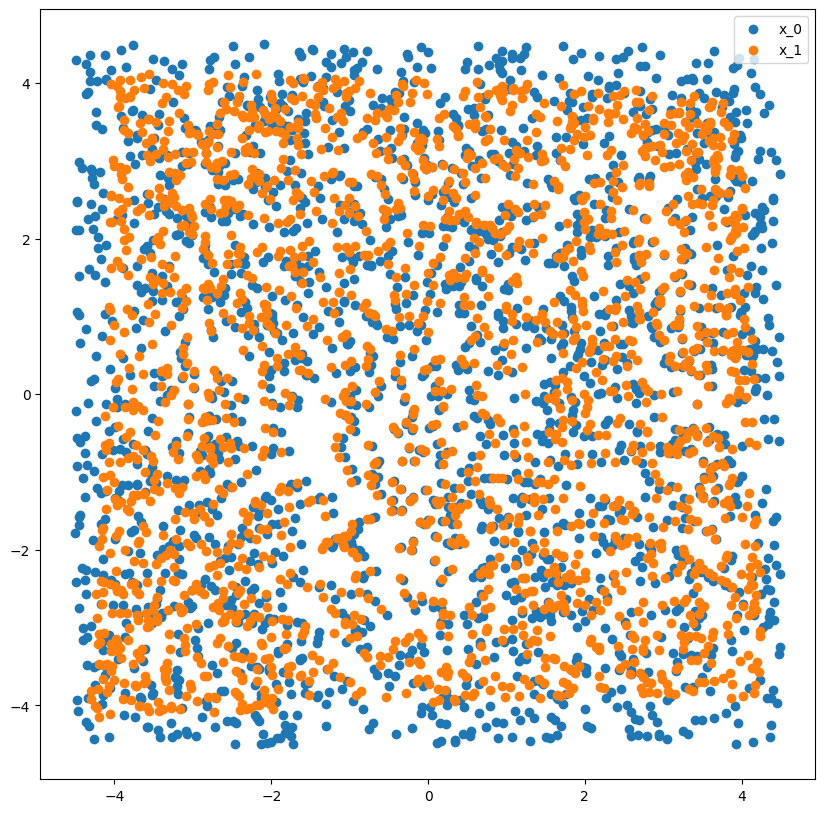

In [3]:
#plotting data
fig = plt.figure(figsize=(10,10))
plt.scatter(data_x0[:,0], data_x0[:,1], label="x_0")
plt.scatter(data_x1[:,0], data_x1[:,1], label="x_1")
plt.legend()
plt.show()

### Task 3.1

In [4]:
delta_t = 0.01
v_hat = estimate_vector(data_x0, data_x1,delta_t)
A_approximated = lstsq(data_x0, v_hat, cond=None)[0]

In [5]:
# Define linear approximation function
def linear_approximation(A, x0, delta_t):
    return x0 + delta_t * np.dot(A, x0.T)

In [6]:
# calculate mse
predicted_x1_all = np.array([linear_approximation(A_approximated, x0, delta_t) for x0 in data_x0])
mse_all = np.mean(np.square(data_x1 - predicted_x1_all))
print(f'Mean Squared Error: {mse_all}')

Mean Squared Error: 0.0186434856287006


In [7]:
Tend = 0.01
x1_hat = generate(data_x0,Tend,A_approximated)

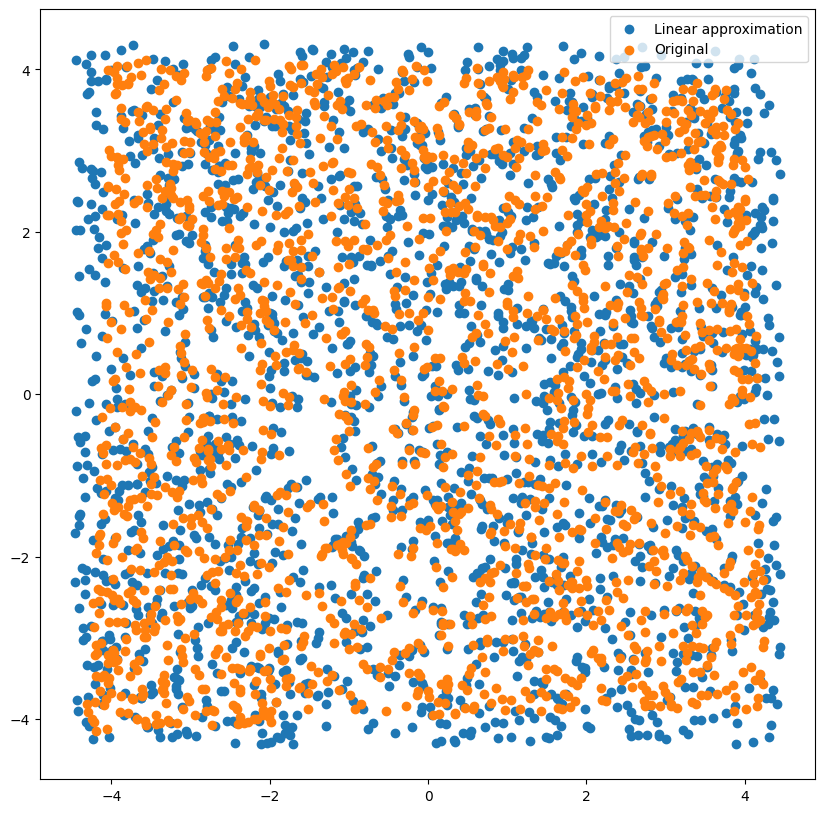

In [8]:
# plot approximated data
fig = plt.figure(figsize=(10,10))
plt.scatter(x1_hat[:,0], x1_hat[:,1], label="Linear approximation")
plt.scatter(data_x1[:,0], data_x1[:,1], label="Original")
plt.legend()
plt.show()

In [9]:
# mse = np.linalg.norm(x1_hat-data_x1) ** 2 / len(data_x1)
# print(mse)

### Task 3.2

In [30]:
# def radial_basis_function(data, l, eps):
#     phi = []
#     np.random.seed(42)
#     x_l = np.random.choice(len(data), l, replace=False)

#     for i in range(l):
#         normalized_values = data - data[x_l[i]]
#         phi_l = np.exp(-np.sum(normalized_values ** 2, axis=1) / eps ** 2)
#         phi.append(phi_l)

#     return np.array(phi).T  # Transpose to have shape (number of data points, number of RBFs)

def radial_basis_function(data, l, eps):
    phi = []

    if len(data) == 1:
        # Handle the case of a single data point separately
        normalized_values = data - data[0]
        phi_l = np.exp(-np.sum(normalized_values ** 2, axis=1) / eps ** 2)
        return phi_l.reshape(-1, 1)  # Reshape to make it a column vector

    np.random.seed(42)
    x_l = np.random.choice(len(data), l)

    for i in range(l):
        normalized_values = data - data[x_l[i]]
        phi_l = np.exp(-np.sum(normalized_values ** 2, axis=1) / eps ** 2)
        phi.append(phi_l)

    return np.array(phi).T  # Transpose to have shape (number of data points, number of RBFs)


In [31]:
# Approximate the vector field using RBF
def rbf_approximation(coefficients):
    return np.dot(phi, coefficients)

In [32]:
# find best combination of l and eps that yields lowest mse
larray = [800, 900, 1000]
epsarray = [1.5, 2, 2.5]
mse_rbf_array = []
mse_rbf_least = 10
eps_least = 0
l_least = 0

for l in larray:
    for eps in epsarray:
        
        phi = radial_basis_function(data_x0, l, eps)
        
        # Perform linear regression to estimate coefficients
        coefficients = lstsq(phi, v_hat, cond=None)[0]

        # Evaluate RBF approximation for all data points
        rbf_approximated_v = np.array(rbf_approximation(coefficients))

        # Calculate Mean Squared Error
        mse_rbf = np.mean(np.square(v_hat - rbf_approximated_v))
        mse_rbf_array.append((l, eps, mse_rbf))

        # Update if the current combination yields lower MSE
        if mse_rbf < mse_rbf_least:
            mse_rbf_least = mse_rbf
            eps_least = eps
            l_least = l
        
print(f'Least mean Squared Error (RBF): {mse_rbf_least} reached for: l={l_least}, eps={eps_least}')

Least mean Squared Error (RBF): 4.070405513144254e-12 reached for: l=1000, eps=2


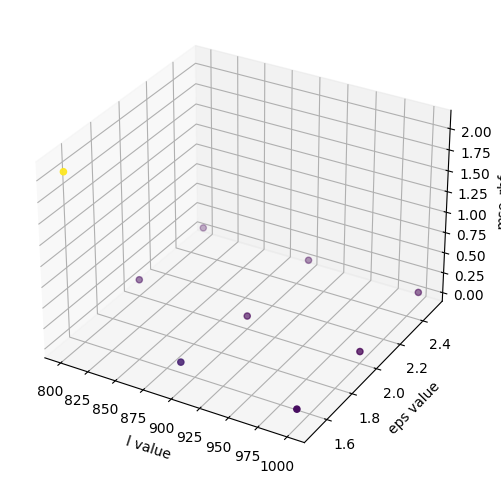

In [33]:
# comparison of l and eps values with their corresponding mse
l, eps, mse_rbf = zip(*mse_rbf_array)

# Convert to numpy arrays
l = np.array(l)
eps = np.array(eps)
mse_rbf = np.array(mse_rbf)

# Get unique values in l and eps
unique_l = np.unique(l)
unique_eps = np.unique(eps)

# Reshape to 2D arrays
l = l.reshape((len(unique_eps), len(unique_l)))
eps = eps.reshape((len(unique_eps), len(unique_l)))
mse_rbf = mse_rbf.reshape((len(unique_eps), len(unique_l)))

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the points with colors based on mse_rbf values
scatter = ax.scatter(l, eps, mse_rbf, c=mse_rbf, cmap='viridis', marker='o')

# Set labels
ax.set_xlabel('l value')
ax.set_ylabel('eps value')
ax.set_zlabel('mse_rbf')
#ax.set_title('3D Surface Plot')

# Show the plot
plt.show()


In [37]:
# predict and plot, copied and adapted, doesn't work :(
import numpy as np
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist

def predict_x1_hat_nonlinear(l, eps, data, end_time=0.1):
    """
    Predicts the future state x1 for a set of initial states x0 by employing a combination of least squares approximation and trajectory solving.
    :param l: Number of basis functions to approximate the nonlinear function.
    :param eps: Bandwidth of the basis functions.
    :param data: Tuple of (initial points x0, known end points x1).
    :param end_time: End time for the simulation.
    :return: List of predicted x1.
    """
    points, targets = data[0], data[1]

    # centers = points[np.random.choice(range(points.shape[0]), size=l)]

    # points = points.reshape(-1, 1)
    # centers = centers.reshape(-1, 1)

    # phi = np.exp(-cdist(points, centers) ** 2 / eps ** 2)
    phi = radial_basis_function(data, l, eps)
    # Reshape phi to 2D array
    phi = phi.reshape(len(points), -1)
    print(phi.shape)

    sol, residuals, rank, singvals = np.linalg.lstsq(a=phi, b=targets, rcond=None)

    def vector_field(t, y, coefficients, phi):
        return phi @ coefficients

    x1_pred = []
    t_eval = np.linspace(0, end_time, 100)

    for i in range(len(data[0])):
        sol_reshaped = sol.reshape(-1, 1)
        sol = solve_ivp(vector_field, [0, end_time], data[0][i], args=(sol_reshaped, phi), t_eval=t_eval)
        x1_pred.append([sol.y[0, -1], sol.y[1, -1]])

    return x1_pred

x1_pred = predict_x1_hat_nonlinear(l_least, eps_least, (data_x0, data_x1))


(2000, 2)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)

In [ ]:
# import matplotlib.pyplot as plt

# # Recreate phi with the optimal l_least and eps_least
# phi_optimal = radial_basis_function(data_x0, l_least, eps_least)

# # Perform linear regression to estimate coefficients with the optimal phi
# coefficients_optimal = lstsq(phi_optimal, v_hat, cond=None)[0]

# # Evaluate RBF approximation for all data points in x1
# phi_x1 = radial_basis_function(data_x1, l_least, eps_least)
# rbf_approximated_v_x1 = np.dot(phi_x1, coefficients_optimal)

# # Plot the RBF-approximated points
# plt.figure(figsize=(8, 8))
# plt.scatter(rbf_approximated_v_x1[:, 0], rbf_approximated_v_x1[:, 1], label='RBF Approximation', alpha=0.7)
# plt.scatter(data_x1[:, 0], data_x1[:, 1], label='Original', alpha=0.7)
# plt.title('RBF Approximation vs Original Data')
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.legend()
# plt.show()


In [25]:
# copied functions, no adaptions

from typing import Union, Iterable, Tuple
from scipy.spatial.distance import cdist

def approx_nonlin_func(data: Union[str, Iterable[np.ndarray]] = "../data/nonlinear_function_data.txt", n_bases: int = 5, eps: float = 0.1,
                       centers: np.ndarray = None):
    """
    Approximate a non-linear function through least squares
    :param data:
        Either str: path to the file containing the data in the format Nx2, col 0 is the data, col 1 the targets.
        Or Iterable containing 2 numpy ndarrays: points and targets
    :param n_bases: the number of basis functions to approximate the nonlinear function
    :param eps: bandwidth of the basis functions
    :param centers: list of center points to compute the basis functions
    :returns: tuple (least squares solution (transposed), residuals, rank of coefficients matrix, singular values of coefficient matrix, 
                    centers, eps and phi (list_of_basis))
    """
    # get coefficients and targets form the data
    points, targets = get_points_and_targets(data)

    # evaluate the basis functions on the whole data and putting each basis' result in an array
    list_of_bases, centers = compute_bases(points=points, centers=centers, eps=eps, n_bases=n_bases)

    # solve least square using the basis functions in place of the coefficients to use linear method with nonlinear function
    sol, residuals, rank, singvals = np.linalg.lstsq(a=list_of_bases, b=targets, rcond=1e-5)
    return sol, residuals, rank, singvals, centers, eps, list_of_bases

def get_points_and_targets(data: Union[str, Iterable[np.ndarray]]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Depending on the type of the parameter 'data', returns correctly the points and the targets
    :param data:
        Either str: path to the file containing the data in the format Nx2, col 0 is the data, col 1 the targets.
        Or Iterable containing 2 numpy ndarrays: points and targets
    :returns: points and targets
    """
    if isinstance(data, str):
        data_path = data
        # read data
        linear_func_data = pd.read_csv(data_path, sep=" ", header=None, dtype=np.float64)
        # divide data into auxiliary variables
        points, targets = linear_func_data.iloc[:, 0], linear_func_data.iloc[:, 1]
        points = np.expand_dims(points, 1)  # add 1 dimension, needed for np.linalg.lstsq
    else:
        if len(data) != 2:
            raise ValueError(f"Parameter data must be either a string or an Iterable of 2 numpy ndarrays, got {len(data)} elements")
        points, targets = data[0], data[1]
    return points, targets
    
def solve_trajectory(x0, x1, funct, args, find_best_dt=False, end_time=0.1, plot=False):
    """
    Solves initial value point problem for a whole dataset of points, up to a certain moment in time
    :param x0: the data at time 0
    :param x1: the data at unknown time step after 0
    :param funct: to get derivative for next steps generation
    :param find_best_dt: if True also the dt where we have lowest MSE is searched
    :param end_time: end time for the simulation
    :param plot: boolean to produce a scatter plot of the trajectory (orange) with the final x1 points in blue
    :returns: points at time end_time, best point in time (getting lowest MSE), lowest MSE
    """
    # initialize variables for find_best_dt procedure
    best_dt = -1
    best_mse = math.inf
    x1_pred = []
    # fixate some times where system must be evaluated
    t_eval = np.linspace(0, end_time, 100)
    sols = []
    for i in range(len(x0)):
        sol = solve_ivp(funct, [0, end_time], x0[i], args=args, t_eval=t_eval)  # solve initial value problem for a given point
        x1_pred.append([sol.y[0, -1], sol.y[1, -1]])  # save the final solution
        if find_best_dt:
            # to find best dt then all the different snapshots in time have to be saved
            sols.append(sol.y)
        # plot the trajectory (orange) and ground truth end point (blue)
        if plot:
            plt.scatter(x1[i, 0], x1[i, 1], c='blue', s=10)
            plt.scatter(sol.y[0, :], sol.y[1, :], c='orange', s=4)
    if find_best_dt:
        # try all the different moments in time, check if it is the best time
        for i in range(len(t_eval)):
            pred = [[sols[el][0][i], sols[el][1][i]] for el in range(len(sols))]
            mse = np.mean(np.linalg.norm(pred - x1, axis=1)**2)
            # if mse found is best yet, update the variables
            if mse < best_mse:
                best_mse = mse
                best_dt = t_eval[i]
    if plot:
        plt.rcParams["figure.figsize"] = (14,14)
        plt.show()
    return x1_pred, best_dt, best_mse

def estimate_vectors(delta_t: float, x0=None, x1=None) -> np.ndarray:
    """
    Estimates the vector field using the finite-difference formula
    :param delta_t: the time difference used as denominator of the time-difference formula
    :param x0: the data at beginning of time delta
    :param x1: the data at end of time delta
    :returns: an approximation of the vectors s.t. v(x0_k) = x1_k
    """
    # read the 2 files containing the vector field data (if data is not given)
    if x0 is None or x1 is None:
        x0, x1 = read_vectorfield_data()
    # estimate the vector field through the finite-difference formula
    vectors = (x1 - x0) / delta_t
    return vectors

points, targets = data_x0[0], data_x0[1]
centers = points[np.random.choice(range(points.shape[0]), size=l)]
# utilize best delta_t, plot results
dt = 0.1
end_time=10
plt.rcParams["figure.figsize"] = (8,8)
v = estimate_vectors(dt, data_x0, data_x1)
C, res, _, _, _, eps, phi = approx_nonlin_func(data=(data_x0,v), n_bases=l, eps=eps, centers=centers)
print("Residual error:",res)
x1_pred, _, _ = solve_trajectory(data_x0, data_x1, rbf_approx, find_best_dt=False, end_time=end_time, args=[centers, eps, C], plot=False)
plt.scatter([el[0] for el in x1_pred], [el[1] for el in x1_pred], c='orange', s=10, label='prediction')
plt.scatter(x1[:,0], x1[:,1], c='blue', s=10, label='ground_truth')
plt.legend()
plt.show()



TypeError: only integer scalar arrays can be converted to a scalar index

### Task 3.3

In [38]:
t_final = 10  # Adjust as needed
delta_t = 0.01
num_steps = int((t_final) / delta_t) + 1

In [39]:
def simulate_system(vector_field, initial_points, t_final, delta_t, coefficients, phi):
    t_span = (0, t_final)
    t_eval = np.linspace(0, t_final, int((t_final) / delta_t) + 1)
    
    # Flatten all initial points
    initial_points_flattened = np.array([point.flatten() for point in initial_points])
    
    # Define a wrapper function for vector_field to handle flattened input
    def vector_field_wrapper(t, y, coefficients, phi):
        # Reshape y to match the original shape of initial_points
        y_reshaped = y.reshape((len(initial_points), 2))
        # Call the original vector_field function
        result = vector_field(t, y_reshaped.flatten(), coefficients, phi)
        # Return the result as a 1D array
        return result.flatten()
    
    # Solve the system for all initial points using the wrapper function
    sol = solve_ivp(vector_field_wrapper, y0=initial_points_flattened.flatten(), t_span=t_span, args=(coefficients, phi), t_eval=t_eval)
    
    # Reshape the solution to match the expected format
    solution = sol.y.reshape((len(initial_points), 2, len(t_eval)))

    return solution

def rbf_approximation_sim(t, y, coefficients, phi):
    # Assuming y is not used, modify as needed
    return phi @ coefficients

In [40]:
initial_points = data_x0

# Simulate the system using the RBF model
solution_rbf = simulate_system(rbf_approximation_sim, initial_points, t_final, delta_t, coefficients, phi)


ValueError: cannot reshape array of size 2 into shape (2000,2)

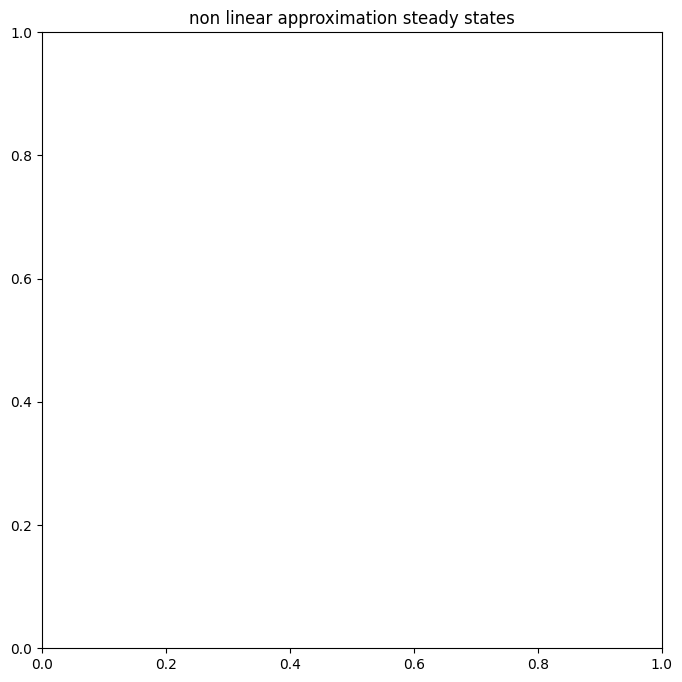

In [29]:
# see steady states, copied and adapted, doesn't work :(

from scipy.spatial.distance import cdist

# Define a wrapper function for vector_field to handle flattened input
def vector_field_wrapper(t, y, coefficients, phi):
    # Reshape y to match the original shape of initial_points
    y_reshaped = y.reshape((len(initial_points), 2))
    # Call the original vector_field function
    result = vector_field(t, y_reshaped.flatten(), coefficients, phi)
    # Return the result as a 1D array
    return result.flatten()

def rbf_approx(t, y, centers, eps, C):
    """
    function to return vector field of a single point (rbf)
    :param t: time (for solve_ivp)
    :param y: single point
    :param centers: all centers
    :param eps: radius of gaussians
    :param C: coefficient matrix, found with least squares
    :return: derivative for point y
    """
    y = y.reshape(1, y.shape[-1])
    phi = np.exp(-cdist(y, centers) ** 2 / eps ** 2)
    return phi @ C

end_time = 50
centers = data_x0[np.random.choice(range(data_x0.shape[0]), replace=False, size=l_least)]
plt.title("non linear approximation steady states")
for i in range(len(data_x0)):
    #coefficients = coefficients.squeeze()
    #sol = solve_ivp(rbf_approx, [0, end_time],  data_x0[i], args=[centers, eps, coefficients])
    t_eval = np.linspace(0, 10, int((10) / 0.01) + 1)
    sol = solve_ivp(vector_field_wrapper, y0=data_x0[i], t_span=(0,10), args=(coefficients, phi), t_eval=t_eval)
    
    # Reshape the solution to match the expected format
    solution = sol.y.reshape((len(initial_points), 2, len(t_eval)))
    plt.scatter(sol.y[0,-1], sol.y[1,-1])
plt.xlim(-4.5, 4.5)
plt.ylim(-4.5, 4.5)
plt.show()

